# PhenoGrpah Pipeline
# 2/4 Cohort-level visualization and statistics
This note book follows the pipeline proposed by Levine et al, focusing on visualize cluster-based phenotype profiling of single cell mass cytometry data. Assuming you have collected the features of surface and signaling phenotypes of hundreds nodes which represent cell populations gained from previous 4-1 part. This part further analysis were conducted on cohort-level visualization and statistics of mass cytometry data.

## Dependecies


In [1]:
#!/usr/bin/env python3
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
import re
import phenograph as pg
import os
from IPython.display import clear_output

### import dataset and visualize surface and signaling phenotypes
Dataset is in .csv format. The form horizontally concatented **SARA scores(224 dimensions), surface markers(16 dimensions) and cell abundance(1 + 18 dimension)** for all cell communities represented by their centroids. Here we print its shape size and column names for indicing and processing. 

In [2]:
# nodes_df = pd.read_csv("results.csv",index_col=0,na_values=0)


nodes_df = pd.read_csv("session_nodes.csv",index_col=0,na_values=0)


print("There are {} cohorts and {} dimensions.".format(nodes_df.shape[0],nodes_df.shape[1]))

There are 637 cohorts and 259 dimensions.


In [3]:
# distinguish health or SJ group in bifurcating manner
# SJ_rows = [('SJ' in i) for i in nodes_df.index]
SJ_rows = [('SJ' in i) for i in nodes_df.index]
nodes_df["if_SJ_Group"] = SJ_rows

print("There are {} cohorts and {} dimensions. {} AML cohorts and {} healthy cohorts.".format(nodes_df.shape[0],
                                                                                              nodes_df.shape[1],
                                                                                             sum(SJ_rows),
                                                                                             nodes_df.shape[0]-sum(SJ_rows)))

There are 637 cohorts and 260 dimensions. 436 AML cohorts and 201 healthy cohorts.


In [4]:
# nodes_df.columns.values

surface_markers = ['CD19', 'CD11b', 'CD34', 'CD45', 'CD123', 'CD33', 'CD47',
       'CD7', 'CD15', 'CD44', 'CD38', 'CD3', 'CD117', 'HLA-DR', 'CD64',
       'CD41']

sara_channels = ['BEZ-235→pPLCg2', 'BEZ-235→p4EBP1',
       'BEZ-235→pAMPK', 'BEZ-235→pSTAT3', 'BEZ-235→pSTAT5', 'BEZ-235→pS6',
       'BEZ-235→pCREB', 'BEZ-235→pc-Cbl', 'BEZ-235→pSTAT1',
       'BEZ-235→pZap70-Syk', 'BEZ-235→pAKT', 'BEZ-235→pRb',
       'BEZ-235→pErk1-2', 'BEZ-235→pP38', 'AICAR→pPLCg2', 'AICAR→p4EBP1',
       'AICAR→pAMPK', 'AICAR→pSTAT3', 'AICAR→pSTAT5', 'AICAR→pS6',
       'AICAR→pCREB', 'AICAR→pc-Cbl', 'AICAR→pSTAT1', 'AICAR→pZap70-Syk',
       'AICAR→pAKT', 'AICAR→pRb', 'AICAR→pErk1-2', 'AICAR→pP38',
       'Flt3L→pPLCg2', 'Flt3L→p4EBP1', 'Flt3L→pAMPK', 'Flt3L→pSTAT3',
       'Flt3L→pSTAT5', 'Flt3L→pS6', 'Flt3L→pCREB', 'Flt3L→pc-Cbl',
       'Flt3L→pSTAT1', 'Flt3L→pZap70-Syk', 'Flt3L→pAKT', 'Flt3L→pRb',
       'Flt3L→pErk1-2', 'Flt3L→pP38', 'G-CSF→pPLCg2', 'G-CSF→p4EBP1',
       'G-CSF→pAMPK', 'G-CSF→pSTAT3', 'G-CSF→pSTAT5', 'G-CSF→pS6',
       'G-CSF→pCREB', 'G-CSF→pc-Cbl', 'G-CSF→pSTAT1', 'G-CSF→pZap70-Syk',
       'G-CSF→pAKT', 'G-CSF→pRb', 'G-CSF→pErk1-2', 'G-CSF→pP38',
       'GM-CSF→pPLCg2', 'GM-CSF→p4EBP1', 'GM-CSF→pAMPK', 'GM-CSF→pSTAT3',
       'GM-CSF→pSTAT5', 'GM-CSF→pS6', 'GM-CSF→pCREB', 'GM-CSF→pc-Cbl',
       'GM-CSF→pSTAT1', 'GM-CSF→pZap70-Syk', 'GM-CSF→pAKT', 'GM-CSF→pRb',
       'GM-CSF→pErk1-2', 'GM-CSF→pP38', 'IFNa→pPLCg2', 'IFNa→p4EBP1',
       'IFNa→pAMPK', 'IFNa→pSTAT3', 'IFNa→pSTAT5', 'IFNa→pS6',
       'IFNa→pCREB', 'IFNa→pc-Cbl', 'IFNa→pSTAT1', 'IFNa→pZap70-Syk',
       'IFNa→pAKT', 'IFNa→pRb', 'IFNa→pErk1-2', 'IFNa→pP38', 'IFNg→pPLCg2',
       'IFNg→p4EBP1', 'IFNg→pAMPK', 'IFNg→pSTAT3', 'IFNg→pSTAT5',
       'IFNg→pS6', 'IFNg→pCREB', 'IFNg→pc-Cbl', 'IFNg→pSTAT1',
       'IFNg→pZap70-Syk', 'IFNg→pAKT', 'IFNg→pRb', 'IFNg→pErk1-2',
       'IFNg→pP38', 'IL-3→pPLCg2', 'IL-3→p4EBP1', 'IL-3→pAMPK',
       'IL-3→pSTAT3', 'IL-3→pSTAT5', 'IL-3→pS6', 'IL-3→pCREB',
       'IL-3→pc-Cbl', 'IL-3→pSTAT1', 'IL-3→pZap70-Syk', 'IL-3→pAKT',
       'IL-3→pRb', 'IL-3→pErk1-2', 'IL-3→pP38', 'IL-6→pPLCg2',
       'IL-6→p4EBP1', 'IL-6→pAMPK', 'IL-6→pSTAT3', 'IL-6→pSTAT5',
       'IL-6→pS6', 'IL-6→pCREB', 'IL-6→pc-Cbl', 'IL-6→pSTAT1',
       'IL-6→pZap70-Syk', 'IL-6→pAKT', 'IL-6→pRb', 'IL-6→pErk1-2',
       'IL-6→pP38', 'IL-10→pPLCg2', 'IL-10→p4EBP1', 'IL-10→pAMPK',
       'IL-10→pSTAT3', 'IL-10→pSTAT5', 'IL-10→pS6', 'IL-10→pCREB',
       'IL-10→pc-Cbl', 'IL-10→pSTAT1', 'IL-10→pZap70-Syk', 'IL-10→pAKT',
       'IL-10→pRb', 'IL-10→pErk1-2', 'IL-10→pP38', 'IL-27→pPLCg2',
       'IL-27→p4EBP1', 'IL-27→pAMPK', 'IL-27→pSTAT3', 'IL-27→pSTAT5',
       'IL-27→pS6', 'IL-27→pCREB', 'IL-27→pc-Cbl', 'IL-27→pSTAT1',
       'IL-27→pZap70-Syk', 'IL-27→pAKT', 'IL-27→pRb', 'IL-27→pErk1-2',
       'IL-27→pP38', 'PMAiono→pPLCg2', 'PMAiono→p4EBP1', 'PMAiono→pAMPK',
       'PMAiono→pSTAT3', 'PMAiono→pSTAT5', 'PMAiono→pS6', 'PMAiono→pCREB',
       'PMAiono→pc-Cbl', 'PMAiono→pSTAT1', 'PMAiono→pZap70-Syk',
       'PMAiono→pAKT', 'PMAiono→pRb', 'PMAiono→pErk1-2', 'PMAiono→pP38',
       'PVO4→pPLCg2', 'PVO4→p4EBP1', 'PVO4→pAMPK', 'PVO4→pSTAT3',
       'PVO4→pSTAT5', 'PVO4→pS6', 'PVO4→pCREB', 'PVO4→pc-Cbl',
       'PVO4→pSTAT1', 'PVO4→pZap70-Syk', 'PVO4→pAKT', 'PVO4→pRb',
       'PVO4→pErk1-2', 'PVO4→pP38', 'SCF→pPLCg2', 'SCF→p4EBP1',
       'SCF→pAMPK', 'SCF→pSTAT3', 'SCF→pSTAT5', 'SCF→pS6', 'SCF→pCREB',
       'SCF→pc-Cbl', 'SCF→pSTAT1', 'SCF→pZap70-Syk', 'SCF→pAKT', 'SCF→pRb',
       'SCF→pErk1-2', 'SCF→pP38', 'TNFa→pPLCg2', 'TNFa→p4EBP1',
       'TNFa→pAMPK', 'TNFa→pSTAT3', 'TNFa→pSTAT5', 'TNFa→pS6',
       'TNFa→pCREB', 'TNFa→pc-Cbl', 'TNFa→pSTAT1', 'TNFa→pZap70-Syk',
       'TNFa→pAKT', 'TNFa→pRb', 'TNFa→pErk1-2', 'TNFa→pP38', 'TPO→pPLCg2',
       'TPO→p4EBP1', 'TPO→pAMPK', 'TPO→pSTAT3', 'TPO→pSTAT5', 'TPO→pS6',
       'TPO→pCREB', 'TPO→pc-Cbl', 'TPO→pSTAT1', 'TPO→pZap70-Syk',
       'TPO→pAKT', 'TPO→pRb', 'TPO→pErk1-2', 'TPO→pP38']

/Users/xiaolibird/anaconda3/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


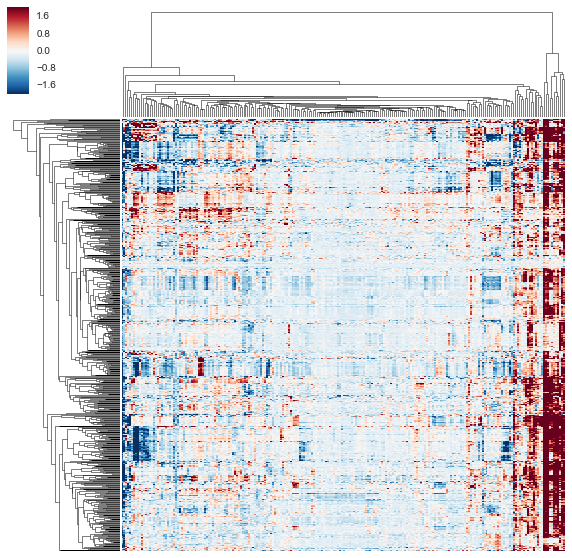

In [94]:
sns.clustermap(nodes_df[sara_channels].values, vmin=-2,vmax=2,
               pivot_kws=None,xticklabels=False,yticklabels=False, method='weighted', metric='euclidean',
               z_score=None, standard_scale=None, figsize=None, cbar_kws=None,
               row_cluster=True, col_cluster=True,
               row_linkage=None, col_linkage=None,
               row_colors=None, col_colors=None, mask=None)

# plt.xlabel("Signaling Responses(224)")
# plt.ylabel("PhenoGrpah Clusters(616)")
# ax = sns.clustermap(nodes_df[sara_channels],vmin=-2,vmax=2,xticklabels=False,yticklabels=False,method="single",cmap='RdBu_r')

This heat map above looks quite like Fig4B

## Defining AML Metaclusters
We performed metaclustering to define cohort-level phenotypes and enable a more rigorous matching of subpopulations across patients. Effectively, this entailed a second application of PhenoGraph to the previously defined PhenoGraph clusters from all patients in the cohort. To identify AML-centric phenotypes and avoid bias toward healthy phenotypes, we chose **exclude the healthy samples** from this analysis and thus perform **metaclustering only on the 425 subpopulations derived from the 16 AML patients**. Each subpopulation was represented by its centroid, a 16-dimensional vector computed by taking the median of each surface marker across all cells in that subpopulation, resulting in a **425 x 16 matrix **(subpopulations x surface markers). PhenoGraph was run on this matrix with the parameter **k=15**, taking into account the smaller number of data points (only 425 clusters, relative to **~1 million cells** in the previous application of PhenoGraph). We note that the resulting graph had a clear modular structure . PhenoGraph partitioned the 425 subpopulations into **14 metaclusters (MCs)** delineating the major cohort phenotypes. Each MC had a mixed patient composition, containing subpopulations **from at least 2 patients and a median of 11 patients**.

**WATCH OUT: 490 AML cohorts and 216 Healthy cohorts in fact. And  436 AML cohorts and 201 healthy cohorts after filtering.** 

In [6]:
n_randstart = 30

selected_channels = surface_markers
centroids_SJ = nodes_df[nodes_df["if_SJ_Group"]==True][selected_channels].values

for j in range(n_randstart):
    communities, graph, Q = pg.cluster(centroids_SJ, 
                                       k=15, directed=True,prune=False, 
                                       min_cluster_size=2, jaccard=True, 
                                       primary_metric='euclidean', n_jobs=-1, q_tol=1e-4)
    
    if j == 0:
        modularity = Q
        mc_labels = communities
    else:
        if Q > modularity: 
            mc_labels = communities
clear_output()

# print(centroids_SJ.shape)
# print("Finished meta Clustering SJ samples and saving results The modularity is {}".format(Q))          
# sort labels 
mc_labels = mc_labels.ravel()
label_SJ = mc_labels
centroids_SJ = centroids_SJ[mc_labels>=0,:]
mc_labels = mc_labels[mc_labels>=0]
n_mc_SJ = sum(np.unique(mc_labels) >= 0) 
mc_centroids_SJ = np.zeros((n_mc_SJ,centroids_SJ.shape[1]))
print("SJ samples are clustered into {} meta-clusters".format(n_mc_SJ))
# for heatmap
for label in range(n_mc_SJ):
    mc_centroids_SJ[label,:] = np.median(centroids_SJ[mc_labels==label,:],0)

    

centroids_H = nodes_df[nodes_df["if_SJ_Group"]==False][selected_channels].values

for j in range(n_randstart):
    communities, graph, Q = pg.cluster(centroids_H, 
                                       k=9, directed=False, prune=True,
                                       min_cluster_size=2, jaccard=True, 
                                       primary_metric='euclidean', n_jobs=-1, q_tol=1e-4)
    
    if j == 0:
        modularity = Q
        mc_labels = communities
    else:
        if Q > modularity: 
            mc_labels = communities
            
            
clear_output()
# print(centroids_H.shape)
# print("Finished meta Clustering H samples and saving results The modularity is {}".format(Q))  

mc_labels = mc_labels.ravel()
label_H = mc_labels

centroids_H = centroids_H[mc_labels>=0,:]
mc_labels = mc_labels[mc_labels>=0]
n_mc_H = sum(np.unique(mc_labels) >= 0) 
mc_centroids_H = np.zeros((n_mc_H,centroids_H.shape[1]))

# print("SJ samples are clustered into {} meta-clusters".format(n_mc_SJ))
# print("SJ samples are clustered into {} meta-clusters".format(n_mc_H))


for label in range(n_mc_H):
    mc_centroids_H[label,:] = np.median(centroids_H[mc_labels==label,:],0)

nodes_df["MC"] = np.hstack((label_H,label_SJ))
nodes_df["MC_2"] = np.hstack((label_H,label_SJ))
nodes_df.to_csv("meta_clustered_results.csv")

print("Finished saving results to csv ")  
print("SJ samples are clustered into {} meta-clusters".format(n_mc_SJ))
print("H samples are clustered into {} meta-clusters".format(n_mc_H))

Finished saving results to csv 
SJ samples are clustered into 14 meta-clusters
H samples are clustered into 19 meta-clusters


According to what is claimed in the Supp, we choose k=15 to Meta-Cluster the cohorts, but for heathy samples it seems impossible to get 20 MCs on around 200 points, because the number of MCs reduce while the k increases. And after tunning we barely approximate the results. With 15 AML MCs and 19 H MCs.

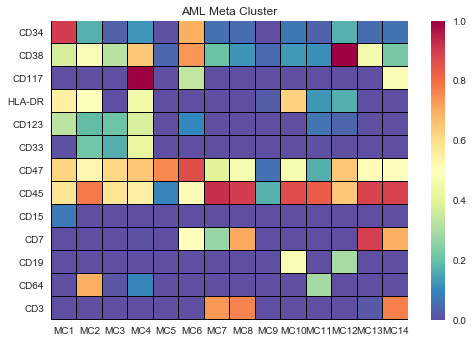

In [7]:
col_names = surface_markers
# print(col_names)
# print(mc_centroids_SJ.shape)
meta_nodes = pd.DataFrame(mc_centroids_SJ,
                          index=['MC{0}'.format(i+1) for i in range(n_mc_SJ) ],
                          columns=col_names)
selected_cols = ['CD34','CD38','CD117','HLA-DR','CD123',
                 'CD33','CD47','CD45','CD15',
                 'CD7','CD19','CD64','CD3']
ax = sns.heatmap(meta_nodes[selected_cols].T,
                 vmin=0,
                 vmax=1.0,
                 linewidths=0.004, 
                 linecolor="black",
                 cmap='Spectral_r') 
plt.title("AML Meta Cluster")

Exclude: 
- 7,8,14 (T Cell) 
- 10,12 （B Cell）
- 13 (NK) 
- 5(erthroblast) 
- 11( myeloid DC)

Included: 
- 1.CD34+ CD38mid HSPC
- 2.CD64+ HLA-DR+ monocyte  
- 3.unknown myeloid
- 4.CD117+ myeloidblast
- 6.CD34+ CD38+ HSPC
- 9.unknown myeloid



## Mapping healthy cells to AML meta clusters with LDA
To evaluate this similarity more formally, we systematically matched cells from healthy bone marrow (H1–H5) with the MC surface marker profiles using linear discriminant analysis (Hastie et al., 2009). A high posterior probability for $MC_k$ indicates that cell $𝑥$ falls within the phenotypic boundaries estimated from the observed expression of subpopulations in $MC_k$. Cells that were an extremely good fit to one of the MCs (with $𝑃(𝑀𝐶 = 𝑘 | 𝑋 = 𝑥) > 0.99$) were considered healthy cognates to that MC.

Specifically, for $𝑁$ cells from healthy donors and $𝑀$ cells from AML patients, with $\delta(c_i = k) =1$ when cell $𝑖$ is associated with metacluster $𝑘$, the score

$s_k = \frac{\frac{1}{N}\sum_{i=1}^{N}\delta(c_i = k)}{\frac{1}{M}\sum_{j=1}^{M}\delta(c_j = k)}$

quantifies whether cells associated with metacluster $𝑘$ were more frequently identified in healthy samples than in leukemic samples. Metaclusters for which $𝑠_𝑘 > 1$ were overrepresented in healthy samples relative to leukemic samples and these included MC 5, 8, 9, 10, 11, 12 and 14.

In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# sample_names = ['H'+str(i) for i in range(1,6)]
# sample_names = ['SJ'+str(i) if i>=10 else 'SJ'+'0'+str(i) for i in range(1,17)]


# create mapping for cell to metacluster labels
cell_to_mc = {}
# sample_names = ['H'+str(i) for i in range(1,6)] + ['SJ'+str(i) if i>=10 else 'SJ'+'0'+str(i) for i in range(1,17)]

sample_names = ['SJ'+str(i) if i>=10 else 'SJ'+'0'+str(i) for i in range(1,17)]
for s in sample_names:
    for nn in nodes_df.index:
        if s in nn:
            cell_to_mc[s] = []
            
for s in sample_names:
    for nn in nodes_df.index:
        if s in nn:
            cell_to_mc[s].append((int(nn.split('/')[1]),nodes_df.loc[nn,"MC"]))
            
#             data = pd.read_csv(s+'/session_data.csv',index_col=0)
#             data["MC"] = 
for i,s in enumerate(sample_names):
    if i == 0:
        data = pd.read_csv(s +'/session_data.csv',index_col=0)
        data = data.loc[data["#condition"].isin([2]),surface_markers+['PhenoGraph']]
        data["MC"] = [-1]*data.shape[0]
        for mapping in cell_to_mc[s]:
            data.loc[data["PhenoGraph"] == mapping[0],"MC"] = mapping[1]
    else:
        temp = pd.read_csv(s+'/session_data.csv',index_col=0)
        temp = temp.loc[temp["#condition"].isin([2]),surface_markers+['PhenoGraph']]
        temp["MC"] = [-1]*temp.shape[0]
        for mapping in cell_to_mc[s]:
            temp.loc[temp["PhenoGraph"] == mapping[0],"MC"] = mapping[1]
        data = pd.concat([data,temp],axis=0)
print(data.shape)

(689692, 18)


In [9]:
data = data.drop(data[data["MC"] == -1].index)
SJ = data


sample_names = ['H'+ str(i) for i in range(1,6)]
for i,s in enumerate(sample_names):
    if i == 0:
        data = pd.read_csv(s +'/session_data.csv',index_col=0)
        data = data.loc[data["#condition"].isin([2]),surface_markers+['PhenoGraph']]
#         data["MC"] = [-1]*data.shape[0]
#         for mapping in cell_to_mc[s]:
#             data.loc[data["PhenoGraph"] == mapping[0],"MC"] = mapping[1]
    else:
        temp = pd.read_csv(s+'/session_data.csv',index_col=0)
        temp = temp.loc[temp["#condition"].isin([2]),surface_markers+['PhenoGraph']]
#         temp["MC"] = [-1]*temp.shape[0]
#         for mapping in cell_to_mc[s]:
#             temp.loc[temp["PhenoGraph"] == mapping[0],"MC"] = mapping[1]
        data = pd.concat([data,temp],axis=0)

Healthy = data

In [10]:
# mapping cells from healthy samples to AML MCs

lda = LinearDiscriminantAnalysis()
lda.fit(SJ[surface_markers],SJ['MC'])
healthy_mc_label = lda.predict(Healthy[surface_markers])
Healthy["MC"] = healthy_mc_label

score= np.zeros(n_mc_SJ)
for i in range(n_mc_SJ):
    score[i] = (Healthy[Healthy["MC"] == i].shape[0]/Healthy.shape[0])/(SJ[SJ["MC"] == i].shape[0]/SJ.shape[0])

/Users/xiaolibird/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:453: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


In [95]:
excluded_mc = np.where(score>=1)
included_mc = np.where(score<1)
# mapping healthy cohorts to AML MCs for temporary visualization
label2 = lda.predict(nodes_df.loc[nodes_df["if_SJ_Group"]==False,surface_markers])
nodes_df.loc[nodes_df["if_SJ_Group"]==False,"MC"] = label2

In [96]:
included_mc

(array([ 0,  1,  3,  5, 11]),)

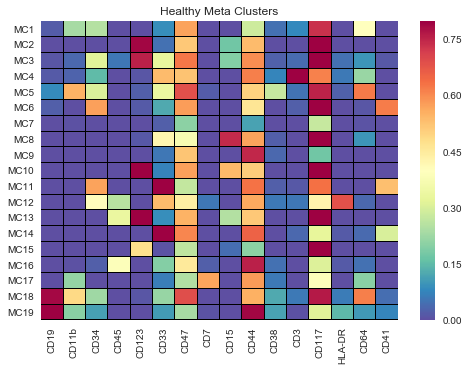

In [97]:
col_names = surface_markers
# print(col_names)
meta_nodes = pd.DataFrame(mc_centroids_H,
                          index=['MC{0}'.format(i+1) for i in range(n_mc_H) ],
                          columns=(col_names[::-1]))
# selected_cols = ['CD34','CD38','CD117',
#                  'HLA-DR','CD123','CD33',
#                  'CD47','CD45','CD15','CD7',
#                  'CD19','CD64','CD3']

selected_cols = surface_markers
ax = sns.heatmap(meta_nodes[selected_cols],
                 vmin=0.0,
                 vmax=0.80,
                 linewidths=0.005, 
                 linecolor="black",
                 cmap='Spectral_r') 
plt.title("Healthy Meta Clusters")
plt.figsize = (16,16)

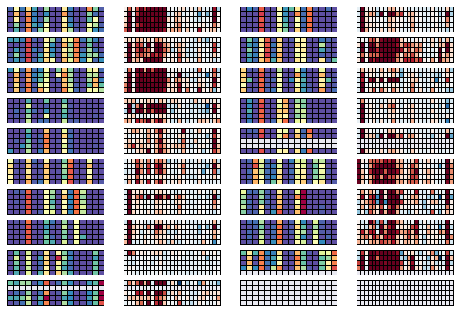

In [98]:
fig,axn = plt.subplots(10, 4, sharex=False, sharey=True)
fig.figsize= (32,32)
temp_sara_cols = ["G-CSF→pSTAT3","IL-3→pSTAT3",
                  "IL-3→pSTAT5","PVO4→pZap70-Syk","PVO4→pP38","G-CSF→pSTAT5",
                  "PVO4→pErk1-2","GM-CSF→pSTAT5","PVO4→pSTAT5","PVO4→pPLCg2",
                  "PVO4→pSTAT3","PVO4→pS6",'GM-CSF→pSTAT3','GM-CSF→pCREB',
                  'PMAiono→pP38','PVO4→pAKT','GM-CSF→pS6','Flt3L→pAKT',
                  'SCF→pAKT','PVO4→pc-Cbl','IL-3→pS6','IL-10→pSTAT3',
                  'GM-CSF→pErk1-2','PVO4→pCREB','G-CSF→pCREB']
sample_names = ['H'+ str(i) for i in range(1,6)]
cmaps = ['Spectral_r','RdBu_r']
vrange = [[0,1],[-2,2]]
for i,ax in enumerate(axn.flat):
    df = nodes_df[(nodes_df["if_SJ_Group"] == False) & (nodes_df["MC_2"] == int(i/2))]
    if i%2 == 0:
        df = df[surface_markers]
    else:
        df = df[temp_sara_cols]
        
    sample_wise_nodes = {}
    for s in sample_names:
        sample_wise_nodes[s] = df.loc[[s in ixx for ixx in df.index],:].median()
    sample_wise_nodes = pd.DataFrame(sample_wise_nodes) 
#     print(sample_wise_nodes)
    sns.heatmap(sample_wise_nodes.T, 
                ax=ax,
                cmap=cmaps[i%2],
                vmin=vrange[i%2][0],
                vmax=vrange[i%2][1],
                linewidths=0.004, 
                linecolor="black",
                yticklabels=False,
                xticklabels=False,
                cbar=False)
#     plt.title("HMC"+str(i))

Excluded: 
- 4(T) 
- 18 19 (B) 
- 17(NK)  
- 9(granulyte)  

Included:
- 1. 
-  12.HSPC!

/Users/xiaolibird/anaconda3/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


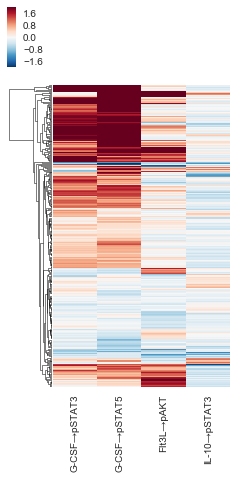

In [19]:
# choose columns according to knowledge

sara_cols = ['G-CSF→pSTAT3','G-CSF→pSTAT5','Flt3L→pAKT','IL-10→pSTAT3']
surface_cols = ['CD34','CD38','CD117','CD45','CD47','HLA-DR','CD64']

Included_SJ_MC = [0,1,2,3,4,5,8]
Included_H_MC = [0,1,2,5,6,7,10,11,12,13,14,15]
# nodes_SJ_Prmitive = nodes_df[(nodes_df["if_SJ_Group"] == True) 
#                              & ( (nodes_df["MC"] == 0) 
#                                  |(nodes_df["MC"] == 2)  
#                                  |(nodes_df["MC"] == 3) 
#                                  |(nodes_df["MC"] == 4)
#                                  |(nodes_df["MC"] == 5)
#                                  |(nodes_df["MC"] == 15)
#                                  |(nodes_df["MC"] == 9)
#                                 |(nodes_df["MC"] == 1)
#                                 |(nodes_df["MC"] == 16)
#                                )
#                             ]

nodes_SJ_Prmitive = nodes_df[(nodes_df["if_SJ_Group"] == True) 
                             & ((nodes_df["MC_2"].isin(Included_SJ_MC)))]

nodes_H_Prmitive = nodes_df[(nodes_df["if_SJ_Group"] == False) 
                             & ( (nodes_df["MC_2"].isin(Included_H_MC)))]

from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
# dist = pdist(nodes_sara.values,metric='euclidean')
# Z = linkage(dist,method='single', metric='euclidean')

# print(a.shape)
nodes_SJ_sara = nodes_SJ_Prmitive[sara_cols]
nodes_SJ_surf = nodes_SJ_Prmitive[surface_cols]


nodes_H_sara = nodes_H_Prmitive[sara_cols]
nodes_H_surf = nodes_H_Prmitive[surface_cols]

# col_names = nodes_surf.columns.values
# nodes_surf_values = nodes_surf.values

# df = [nodes_H_sara,nodes_H_surf,nodes_SJ_sara,nodes_SJ_surf]
# cmaps = ['RdBu_r','Spectral_r','RdBu_r','Spectral_r']
# vrange = [[-2,2],[0,1],[-2,2],[0,1]]
# figsizes = [(4,7),(7,7)]
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6), sharey=True)
ax = sns.clustermap(nodes_SJ_sara,vmin=-2,vmax=2, 
                    yticklabels=False,cmap='RdBu_r',
                    col_cluster=False,figsize=(4,7)) 

indices_order1 = ax.dendrogram_row.reordered_ind
# print(np.sort(indices_order))=

# fig,axn = plt.subplots(2, 2, sharex=False, sharey=True)
# gs = gridspec.GridSpec(2, 2, width_ratios=[4, 7])
# for i,ax in enumerate(axn.flat):
# R = dendrogram(Z,orientation='left',ax = axn[0])
#     plt.subplot(gs[i])
#     sns.heatmap(df[i], 
#                 ax=ax,
#                 cmap=cmaps[i],
#                 vmin=vrange[i][0],
#                 vmax=vrange[i][1],
#                 yticklabels=False,
#                 xticklabels=False,
#                 cbar=False)

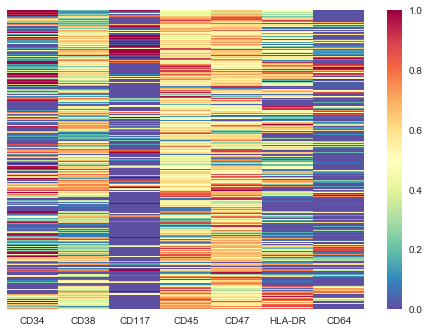

In [20]:
ax = sns.heatmap(nodes_SJ_surf.iloc[indices_order1,:],
                 vmin=0.0,
                 vmax=1,
                 cmap='Spectral_r',yticklabels= False)

/Users/xiaolibird/anaconda3/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


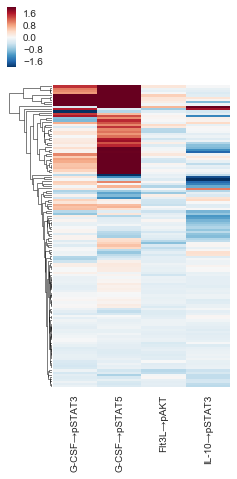

In [34]:
ax = sns.clustermap(nodes_H_sara,vmin=-2,vmax=2, 
                    yticklabels=False,cmap='RdBu_r',
                    col_cluster=False,figsize=(4,7)) 

indices_order2 = ax.dendrogram_row.reordered_ind

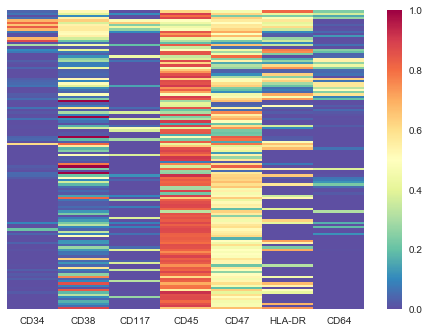

In [35]:
ax = sns.heatmap(nodes_H_surf.iloc[indices_order2,:],
                 vmin=0.0,
                 vmax=1,
                 cmap='Spectral_r',yticklabels= False)

In [18]:
# from scipy.spatial.distance import pdist
# from scipy.cluster.hierarchy import linkage
# from scipy.cluster.hierarchy import dendrogram
# dist = pdist(nodes_sara.values,metric='euclidean')
# Z = linkage(dist,method='single', metric='euclidean')
# R = dendrogram(Z,orientation='left',no_plot=True)
# print(a.shape)

## Significance test for the decoupling of AML and Healthy samples


/Users/xiaolibird/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/xiaolibird/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


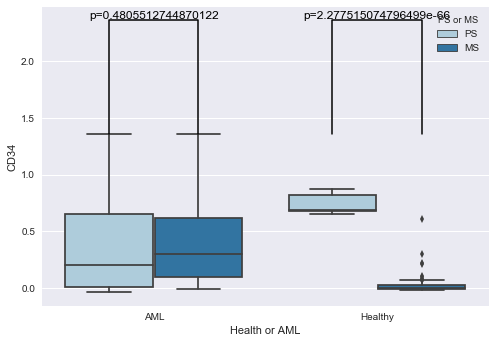

In [86]:
marker = ["CD34"]
SJ_PS = [0,5]
SJ_MS = [1,2,3,4,8]
H_PS = [11]
H_MS = [0,1,2,4,5,6,7,9,10,12,13,14,15,16]

# nodes_SJ_Prmitive = nodes_df[(nodes_df["if_SJ_Group"] == True) 
#                              & ( (nodes_df["MC_2"].isin(SJ_PS)) )]
nodes_SJ_Primitive = nodes_df[(nodes_df["if_SJ_Group"] == True)].ix[indices_order1[40:]]
nodes_SJ_Primitive = nodes_SJ_Primitive
nodes_SJ_Prmitive.loc[:,"PS or MS"] = ["PS"]*nodes_SJ_Prmitive.shape[0]
nodes_SJ_Prmitive.loc[:,"Health or AML"] = ["AML"]*nodes_SJ_Prmitive.shape[0]

# nodes_SJ_Mature = nodes_df[(nodes_df["if_SJ_Group"] == True) 
#                              & ( (nodes_df["MC_2"].isin(SJ_MS)) )]
nodes_SJ_Mature = nodes_df[(nodes_df["if_SJ_Group"] == True)].ix[indices_order1[:40]]
nodes_SJ_Mature = nodes_SJ_Mature
nodes_SJ_Mature.loc[:,"PS or MS"] = ["MS"]*nodes_SJ_Mature.shape[0]
nodes_SJ_Mature.loc[:,"Health or AML"] = ["AML"]*nodes_SJ_Mature.shape[0]

nodes_H_Prmitive = nodes_df[(nodes_df["if_SJ_Group"] == False) 
                             & ( (nodes_df["MC_2"].isin(H_PS)) )]
nodes_H_Prmitive.loc[:,"PS or MS"] = ["PS"]*nodes_H_Prmitive.shape[0]
nodes_H_Prmitive.loc[:,"Health or AML"] = ["Healthy"]*nodes_H_Prmitive.shape[0]

nodes_H_Mature = nodes_df[(nodes_df["if_SJ_Group"] == False) 
                             & ( (nodes_df["MC_2"].isin(H_MS)))]
nodes_H_Mature.loc[:,"PS or MS"] = ["MS"]*nodes_H_Mature.shape[0]
nodes_H_Mature.loc[:,"Health or AML"] = ["Healthy"]*nodes_H_Mature.shape[0]

selected_cols_temp = ["CD34","PS or MS","Health or AML"]
expression = pd.concat([nodes_SJ_Prmitive[selected_cols_temp],
                        nodes_SJ_Mature[selected_cols_temp],
                        nodes_H_Prmitive[selected_cols_temp],
                        nodes_H_Mature[selected_cols_temp]],axis=0)
sns.boxplot(x="Health or AML", y="CD34", hue="PS or MS", data=expression, palette="Paired")
# sns.despine(trim=False)

from scipy import stats
t, p = stats.ttest_ind(expression[(expression["Health or AML"] == "AML") 
                                                  & (expression["PS or MS"] == "PS")]["CD34"],
                                      expression[(expression["Health or AML"] == "AML") 
                                                  & (expression["PS or MS"] == "MS")]["CD34"])
# statistical annotation
x1,x2 = -0.2,0.2
y, h, col = expression['CD34'].max(), 1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, 
         "p={}".format(p), ha='center', va='bottom', color=col)

t, p = stats.ttest_ind(expression[(expression["Health or AML"] == "Healthy") 
                                                  & (expression["PS or MS"] == "PS")]["CD34"],
                                      expression[(expression["Health or AML"] == "Healthy") 
                                                  & (expression["PS or MS"] == "MS")]["CD34"])

x1,x2 = 0.8,1.2
y, h, col = expression['CD34'].max(), 1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, 
         "p={}".format(p), ha='center', va='bottom', color=col)

plt.show()

## Visualize landscape with t-SNE
We chose to exclude normal lymphoid subpopulations to focus on the myeloid, leukemic, and progenitor populations and to get finer resolution on the relationships between them. We used the previously defined MCs to determine which populations were lymphoid cell types. Specifically, AML metaclusters MC 5, 9, 11, 12, and 14 were excluded as normal lymphoid or erythroid cells in leukemic samples (Fig. 3B–C). Similarly, healthy metaclusters HMC 2–8, 11, 13, 16, and 19 were excluded as lymphoid (Data S3A). The remaining **360 subpopulations** (76 healthy and 284 AML) were used to construct the cohort landscape shown in Fig. 3A. We chose to simultaneously map subpopulations from both healthy and leukemic samples, so the healthy cell types could act as “landmarks” to aid interpretation of the leukemic subpopulations. All t- SNE mappings were computed using the Barnes-Hut C++ implementation (van der Maaten, 2014; http://lvdmaaten.github.io/tsne/) with **perplexity = 30 and theta = 0**.

In [117]:
a = (nodes_df["if_SJ_Group"] == True) 
b = nodes_df["MC_2"].isin(Included_SJ_MC)
c = nodes_df["if_SJ_Group"] == False
d = nodes_df["MC_2"].isin(Included_H_MC)
selected_nodes_for_vis = (a.values & b.values)  | (c.values & d.values)

print("{} nodes were included for landscape".format(sum(selected_nodes_for_vis)))

445 nodes were included for landscape


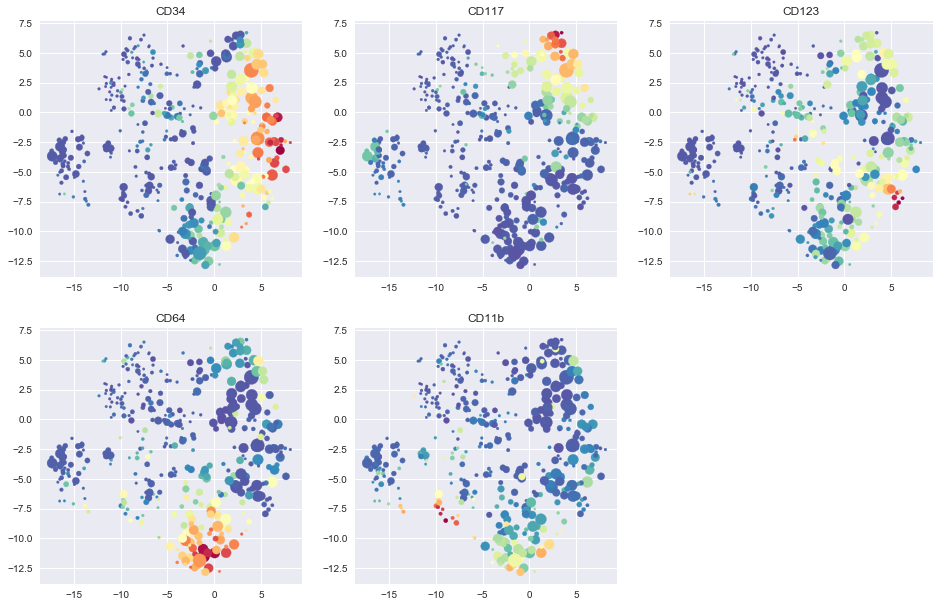

In [118]:
from sklearn.manifold import TSNE

selected_col = surface_markers

data = nodes_df[selected_col].values[selected_nodes_for_vis]
cluster_size = nodes_df["abundance"].values[selected_nodes_for_vis]
model = TSNE(n_components=2, random_state=2,perplexity=100,angle=0.1,init='pca')
Y = model.fit_transform(data)
plt.figure(1,figsize=(16,16))
# sns.set(style="white", context="talk")
for i,channel in enumerate(["CD34","CD117","CD123","CD64","CD11b"]):
    plt.subplot(3,3,i+1)
    plt.scatter(Y[:,0], 
                Y[:,1],
                s= 200/max(cluster_size[:])*cluster_size[:]+5,
                c=nodes_df[selected_nodes_for_vis==True][channel],
                cmap='Spectral_r',
                alpha=1.0)
    plt.title(channel)

In [119]:
# gate ID
gates = []
for i in range(5):
    i=i+1
    gates.append("H"+str(i))
for i in range(16):
    i=i+1
    if i<10:       
        gates.append("SJ0"+str(i))
    else:
        gates.append("SJ"+str(i))

gate_belong = []
    
for xx in nodes_df.index[selected_nodes_for_vis]:
    for a,b in enumerate(gates):
        if b in xx:
            gate_belong.append(a+1)

gate_belong = np.array(gate_belong)
# pool heathy samples
# gate_belong[gate_belong<=5] = 1
# MC ID          
centroids_pool = nodes_df[selected_col].values[selected_nodes_for_vis,:]
# for j in range(1):
#     communities, graph, Q = pg.cluster(centroids_pool, 
#                                        k=15, directed=True, prune=False, 
#                                        min_cluster_size=2, jaccard=True, 
#                                        primary_metric='euclidean', n_jobs=-1, q_tol=1e-4)
#     clear_output()
#     if j == 0:
#         modularity = Q
#         mc_labels = communities
#     else:
#         if Q > modularity: 
#             mc_labels = communities
pool_labels = nodes_df["MC"].values[selected_nodes_for_vis]

/Users/xiaolibird/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 637 but corresponding boolean dimension is 445
/Users/xiaolibird/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 637 but corresponding boolean dimension is 445


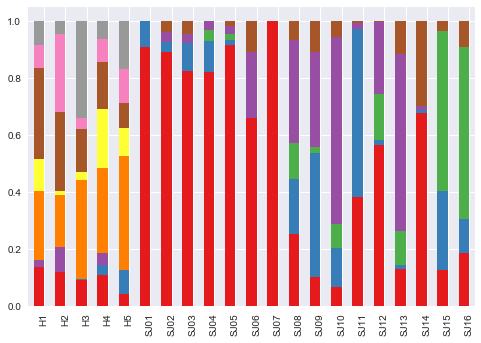

In [120]:
# stack chart
abundance_slice = np.array(nodes_df["abundance"].values)
abundance_summary = np.zeros((len(gates),sum(np.unique(pool_labels)>=0)))
for i,g in enumerate(gates):
    total_cell = 0
    for j,c in enumerate(np.sort(np.unique(pool_labels[pool_labels>=0]))):  
            temp_r = (gate_belong == i+1) & (pool_labels == j)
#             print (gate_belong == i+1)
            total_cell = total_cell + sum(abundance_slice[temp_r])
            abundance_summary[i,j] = sum(abundance_slice[temp_r])
    abundance_summary[i,:] = abundance_summary[i,:]/total_cell
            


abundance_summary = pd.DataFrame(abundance_summary,index=gates,
                                 columns=["MC{}".format(x+1) for x in np.sort(np.unique(pool_labels[pool_labels>=0]))])



abundance_summary.plot(kind='bar',stacked=True,cmap="Set1",legend=False,position=1)

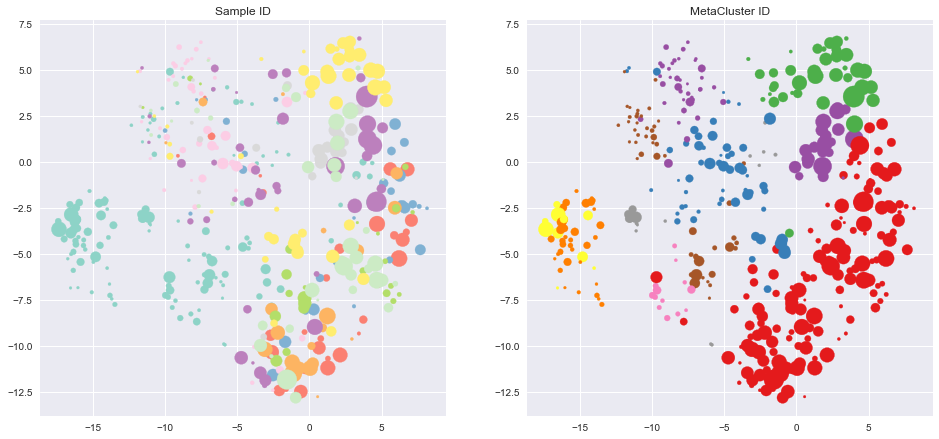

In [121]:
# print(abundance_summary)

# plt.barh(abundance_summary,width=2)

# print(len(selected_nodes_for_vis))
gate_belong[gate_belong<=5] = 1
# gate_belong[gate_belong>5] = 2
plt.figure(2,figsize=(16,16))


plt.subplot(2,2,1)  
plt.scatter(Y[:,0], Y[:,1],
            s= 450/max(cluster_size[:])*cluster_size[:]+5,
            c=gate_belong[:],cmap='Set3',alpha=1.0)
plt.title('Sample ID')


plt.subplot(2,2,2)  
plt.scatter(Y[:,0], Y[:,1],
            s= 450/max(cluster_size[:])*cluster_size[:]+5,
            c=pool_labels[:],cmap='Set1',alpha=1.0)
plt.title('MetaCluster ID')

# plt.subplot(2,2,3)  
# abundance_summary.plot(kind='bar',stacked=True)
# plt.title('Frequency in each MC')

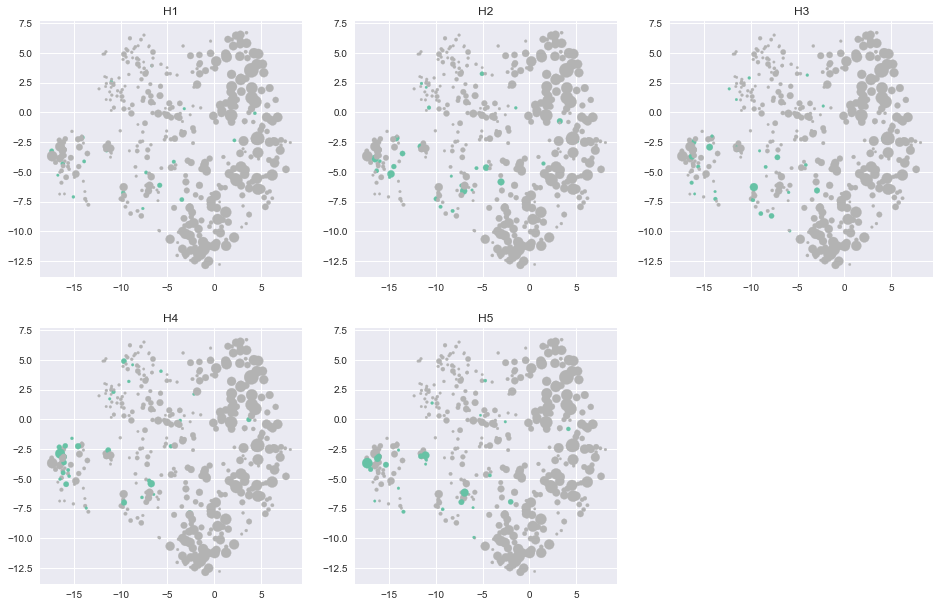

In [158]:

selected_col = surface_markers
xxx = nodes_df.index[selected_nodes_for_vis].astype("str")
data = nodes_df[selected_col].values[selected_nodes_for_vis]
cluster_size = nodes_df["abundance"].values[selected_nodes_for_vis]
model = TSNE(n_components=2, random_state=2,perplexity=100,angle=0.1,init='pca')
Y = model.fit_transform(data)
plt.figure(1,figsize=(16,16))
# sns.set(style="white", context="talk")
for i,s in enumerate(sample_names):
    plt.subplot(3,3,i+1)
    index = np.array([s in n for n in xxx])
#     print(index.shape)
#     print(Y.shape)
    plt.scatter(Y[:,0], 
                Y[:,1],
                s= 200/max(cluster_size[:])*cluster_size[:]+5,
                c = index,
                cmap = "Set2_r",
                alpha=1.0)
    plt.title(s)

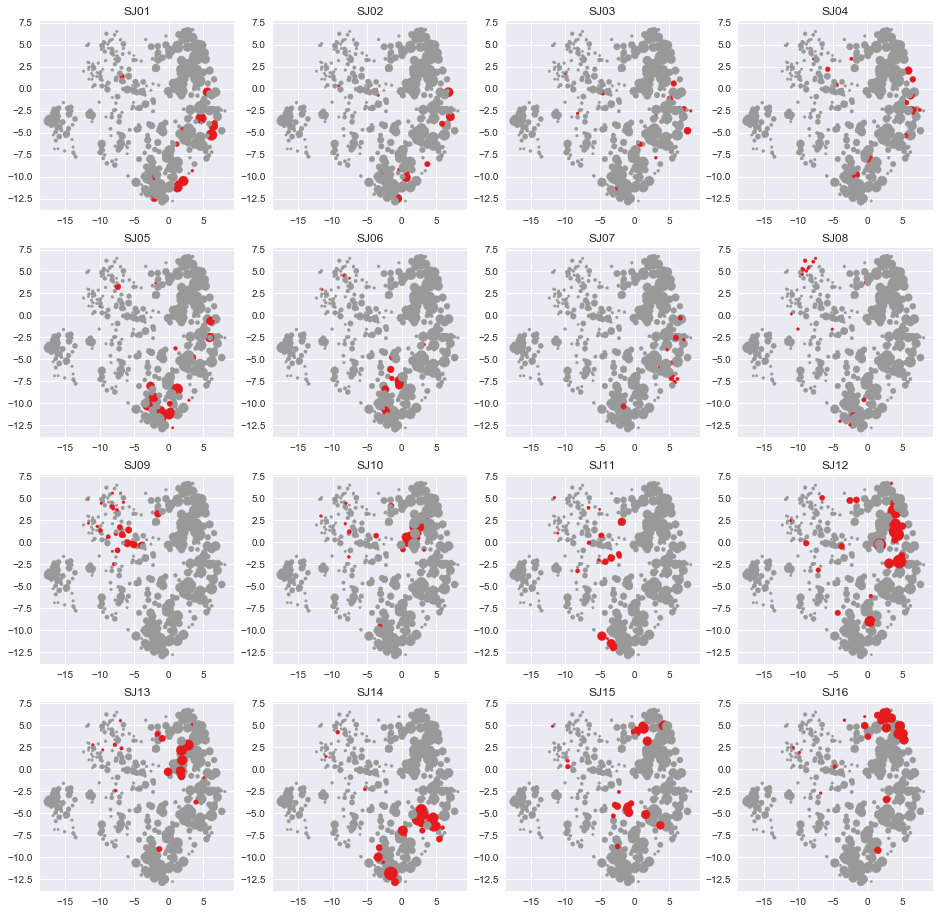

In [160]:
gates = []
for i in range(16):
    i=i+1
    if i<10:       
        gates.append("SJ0"+str(i))
    else:
        gates.append("SJ"+str(i))
        
        
selected_col = surface_markers
xxx = nodes_df.index[selected_nodes_for_vis].astype("str")
data = nodes_df[selected_col].values[selected_nodes_for_vis]
cluster_size = nodes_df["abundance"].values[selected_nodes_for_vis]
model = TSNE(n_components=2, random_state=2,perplexity=100,angle=0.1,init='pca')
Y = model.fit_transform(data)
plt.figure(1,figsize=(16,16))
# sns.set(style="white", context="talk")
for i,s in enumerate(gates):
    plt.subplot(4,4,i+1)
    index = np.array([s in n for n in xxx])
#     print(index.shape)
#     print(Y.shape)
    plt.scatter(Y[:,0], 
                Y[:,1],
                s= 200/max(cluster_size[:])*cluster_size[:]+5,
                c = index,
                cmap = "Set1_r",
                alpha=1.0)
    plt.title(s)

## Identification of Signaling Responses that Are Predictive of Healthy Cell Types
Metaclustering of the **5 normal marrows** (described above) identified **20 healthy cell types** (Data S3A), each of which was associated with a surface phenotype and a signaling phenotype of 224 signaling responses (i.e. response of phospho-marker X to perturbation Y). While surface markers are typically used to distinguish healthy immune cell types, we **tested whether signaling responses could inform cell type in general**, as well as **highlighting which signaling responses were most informative** in this regard.
To identify signaling responses significantly associated with the healthy cell type assignments, the 20 cell types were used as a categorical variable for the healthy subpopulations in **analysis of variance (ANOVA)** of each signaling response.

In [49]:
import scipy.stats as stats
data = nodes_df[nodes_df["if_SJ_Group"] == False]
# print(data.shape)
data = data[sara_channels].join(data["MC_2"])
data = data[data["MC_2"]>=0]

F_criticals = []
p_vals = []
for c in sara_channels:
    arg = []
    for mc in (data["MC_2"].unique()):
#         print(mc)
        arg.append(data[data["MC_2"] == mc][c].values)
#     print((arg))
    F,p = stats.f_oneway(*arg)
    F_criticals.append(F)
    p_vals.append(p)

In [50]:
ANOVA_res = pd.DataFrame(np.reshape(np.hstack((F_criticals,p_vals)),(2,len(p_vals))).T,
                         index=sara_channels,columns=['F','p'])
ANOVA_res = ANOVA_res.sort_values(['p'])
excluded_saras = []
for c in ANOVA_res.index:
    if ("BEZ"  in c) or ("TNFa"  in c) or ("TPO"  in c) :
        excluded_saras.append(c)
        
        
ANOVA_res_dropped = ANOVA_res.drop(excluded_saras)


print("The 4 most significant sara were {}".format(ANOVA_res_dropped.index[0:4]))
print("From author: {}".format(["G-CSF→pSTAT3","IL-3→pSTAT3","IL-3→pSTAT5","PVO4→pZap70-Syk"]))

The 4 most significant sara were Index(['G-CSF→pSTAT3', 'GM-CSF→pSTAT5', 'IL-3→pSTAT3', 'IL-10→pSTAT5'], dtype='object')
From author: ['G-CSF→pSTAT3', 'IL-3→pSTAT3', 'IL-3→pSTAT5', 'PVO4→pZap70-Syk']


In [89]:
ANOVA_res_dropped.to_csv("ANOVA_res_dropped.csv")

/Users/xiaolibird/anaconda3/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


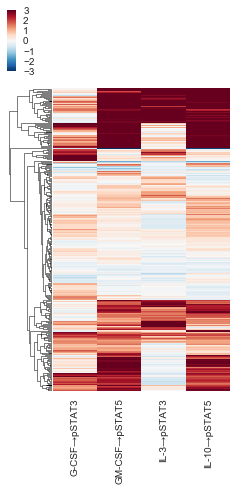

In [78]:
sig_sara_cols = ANOVA_res_dropped.index[0:4]
nodes_sara = nodes_SJ_Prmitive[sig_sara_cols]

ax = sns.clustermap(nodes_sara,vmin=-3,vmax=3, 
                    yticklabels=False,cmap='RdBu_r',
                    col_cluster=False,figsize=(4,7))

In [79]:
data = nodes_df[nodes_df["if_SJ_Group"] == False]
# print(data.shape)
data = data[surface_markers].join(data["MC_2"])
data = data[data["MC_2"]>=0]

F_criticals = []
p_vals = []
for c in surface_markers:
    arg = []
    for mc in (data["MC_2"].unique()):
#         print(mc)
        arg.append(data[data["MC_2"] == mc][c].values)
#     print((arg))
    F,p = stats.f_oneway(*arg)
    F_criticals.append(F)
    p_vals.append(p)
    
ANOVA_res_surface = pd.DataFrame(np.reshape(np.hstack((F_criticals,p_vals)),(2,len(p_vals))).T,
                         index=surface_markers,columns=['F','p'])
ANOVA_res_surface = ANOVA_res_surface.sort_values(['p'])

In [80]:
ANOVA_res_surface.to_csv("ANOVA_res_surface.csv")

/Users/xiaolibird/anaconda3/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


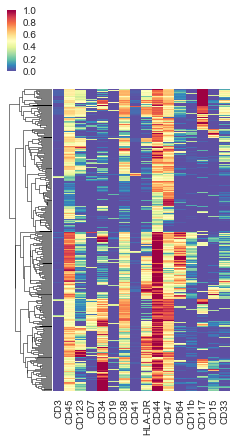

In [81]:
sig_surf_cols = ANOVA_res_surface.index
nodes_surf = nodes_SJ_Prmitive[sig_surf_cols]
# indices_order = ax.dendrogram_row.reordered_ind 
ax = sns.clustermap(nodes_surf,vmin=0,vmax=1, 
                    yticklabels=False,cmap='Spectral_r',
                    col_cluster=False,figsize=(4,7))

## PhenoGraph Classification

Rescale euclidean distance with $-log(p)$

crossvalidation



In [102]:
ANOVA_res_pool = pd.concat((ANOVA_res,ANOVA_res_surface),axis=0)
ANOVA_res_pool = ANOVA_res_pool.T
data = nodes_df[nodes_df["if_SJ_Group"] == False]
# print(data.shape)
data = data[surface_markers+sara_channels].join(data["MC_2"])
data = data[data["MC_2"]>=0]

for c in surface_markers+sara_channels:
    data[c] = data[c] * np.sqrt(-np.log(ANOVA_res_pool.loc['p',c]))

In [103]:
from sklearn.metrics import accuracy_score
# 5-cross validation 1 test and 4 trains
leave_out = ["H1","H2","H3","H4","H5"]
ccr = []

selected_channels = sara_channels
for lo in leave_out: 
    test = [lo in x for x in data.index]
    train = [lo not in x for x in data.index]

    test = data.ix[test]
    train = data.ix[train]
    
    test_set = test[selected_channels].values
#     test_set = test[surface_markers].values
    train_set = []
    for xx in np.sort(np.unique(train["MC_2"].values)):
        if xx >= 0:
            temp = train[train["MC_2"] == (xx)]
            temp = train[selected_channels]
            train_set.append(temp)
        
    c, p = pg.classify(train_set,test_set,k=9,metric='euclidean', n_jobs=4)
#     print(c)
    ground_truth = test["MC_2"].values
#     temp = precision_recall_fscore_support(ground_truth,c,average='weighted')
    ccr.append(accuracy_score(ground_truth,c))
    clear_output()
print("Average correct classification of Healthy Samples is {} %".format(np.mean(ccr)*100))

Average correct classification of Healthy Samples is 6.953287474004159 %


## PhenoGraph Classification of Leukemic Subpopulations

In [98]:
data = nodes_df[surface_markers+sara_channels].join(nodes_df[["MC_2","if_SJ_Group","abundance"]])
data = data[data["MC_2"]>=0]
for c in surface_markers+sara_channels:
    data[c] = data[c] * np.sqrt(-np.log(ANOVA_res_pool.loc['p',c]))
test = data[data["if_SJ_Group"] == True]
train = data[data["if_SJ_Group"] == False]


test_set = test[sara_channels].values
train_set = []
for xx in np.sort(np.unique(train["MC_2"].values)):
    if xx >= 0:
        temp = train[train["MC_2"] == (xx)]
        temp = train[sara_channels]
        train_set.append(temp)

c, p = pg.classify(train_set,test_set,k=15,metric='euclidean', n_jobs=4)
test["IFPC"] = c




test_set = test[surface_markers].values
train_set = []
for xx in np.sort(np.unique(train["MC_2"].values)):
    if xx >= 0:
        temp = train[train["MC_2"] == (xx)]
        temp = train[surface_markers]
        train_set.append(temp)

c, p = pg.classify(train_set,test_set,k=15,metric='euclidean', n_jobs=4)
test["SDPC"] = c
clear_output()
# print("Average correct classification of Healthy Samples is {} %".format(np.mean(ccr)))

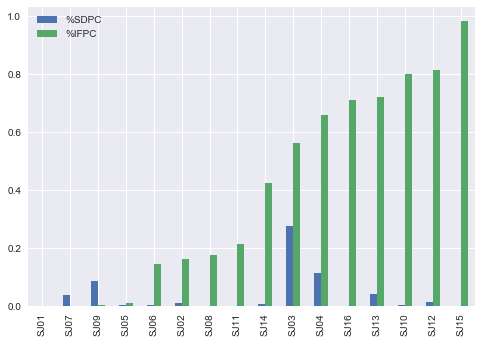

In [103]:
SJ_G = np.arange(16)

Primitive_label = 12

row_n = []
IFPC = []
SDPC = []
for i in SJ_G:
    i = i + 1
    if i < 10:
        i = "0" + str(i)    
    sample = "SJ" + str(i)
    
    row_n.append(sample)
#     print(sample)
    temp = test.ix[[(sample in x) for x in test.index]]
#     print (temp.index)
    SDPC.append(temp[temp["SDPC"] == Primitive_label]["abundance"].sum()/temp["abundance"].sum())
    IFPC.append(temp[temp["IFPC"] == Primitive_label]["abundance"].sum()/temp["abundance"].sum())
    
Primitive_df = pd.DataFrame(np.transpose(np.vstack((np.tile(SDPC,(1,)),np.tile(IFPC,(1,))))),
                            index = row_n, 
                            columns=["%SDPC","%IFPC"])
Primitive_df = Primitive_df.sort_values("%IFPC",ascending=True)
Primitive_df.plot.bar();

## Informative Signaling Phenotypes for Distinguishing the Primitive Subpopulations

In [132]:
# CVA for SJs
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

test_set = nodes_df[nodes_df["if_SJ_Group"] == True][sara_channels].values

lda = LinearDiscriminantAnalysis(n_components=5,store_covariance=True)
HSPC_label = 11
# lda = LinearDiscriminantAnalysis(n_components=2)
target = test_set["MC_2"].values
target[target==12] = 0
target[target!=12] = 1

lda.fit(X = test_set, y = target)

/Users/xiaolibird/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

NameError: name 'lda_result' is not defined

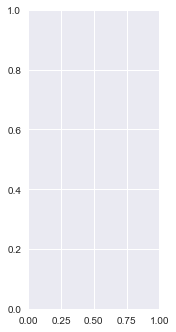

In [133]:
plt.subplot(1,3,1)
plt.scatter(lda_result[target==0, 0], lda_result[target==0, 1], color='r')
plt.scatter(lda_result[target==1, 0], lda_result[target==1, 1], color='b') 
plt.title('LDA on SARA channels')

## Gene Expression Signatures

In [227]:
# load GEO files

# transform

# split SJ12

# leave-2-out 

# choose genes most frequently in top 1% and deviation across data subsets of less than 5%

## Survival Analysis


In [48]:
# load 242 patients

# preprocess

# KM

#